# CLUSTERING TECHNIQUES

## USE OF DATASETS WITH GROUND TRUTH FOR COMPARING THE DIFFERENT TECHNIQUES

### FIRST DATASET - REUTERS NEWS - A BASELINE DATASET WITH ONLY TWO LABELS (GROUND TRUTH K=2)

In [1]:
import pandas as pd
import numpy as np
import spacy

#load the dataset
dataset_filepath = 'datasets/IMDB_Dataset_Sentiment.csv'
initial_df = pd.read_csv(dataset_filepath)
df_cols = initial_df.columns.to_list()
print(f'The length of the dataset is: {len(initial_df)}')
print(df_cols)
print(f'The total labels are: {initial_df.sentiment.unique()}')

The length of the dataset is: 50000
['review', 'sentiment']
The total labels are: ['positive' 'negative']


### CREATE THE NECESSARY UTILS FOR PREPARING THE DATA

In [11]:
from sklearn.preprocessing import LabelEncoder
from utils.load_pretrained_spacy_model import load_pretrained_model

#define the column name of the text
text_col = 'review'

# load the pretrained spacy model
df, nlp = load_pretrained_model(df=initial_df, length_of_final_data=100, text_col=text_col)

# Initialize the LabelEncoder
label_encoder = LabelEncoder()
# Convert the string labels to integer labels
labels = label_encoder.fit_transform(df['sentiment'])

The language of the dataset is: en


#### USE A SENTENCE TRANSFORMER FOR VECTORIZE THE SENTENCES

### 1ST CLUSTERING TECHNIQUE: KMEANS

We are going to implement the original KMeans without using any constraints. For transforming the data we are going to use TF-IDF and FastText embeddings.

#### USING TF-IDF VECTORIZATION

C:\1. Python\LLM_mods_Topic_Modelling\venv\Lib\site-packages\sklearn\feature_extraction\text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
C:\1. Python\LLM_mods_Topic_Modelling\venv\Lib\site-packages\sklearn\feature_extraction\text.py:406: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ca', 'nt'] not in stop_words.
  warnings.warn(


Sentences transformed successfully via TF-IDF vectorizer


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:10<00:00,  4.88it/s]


The optimum kappa based on Silhouette score is: 45


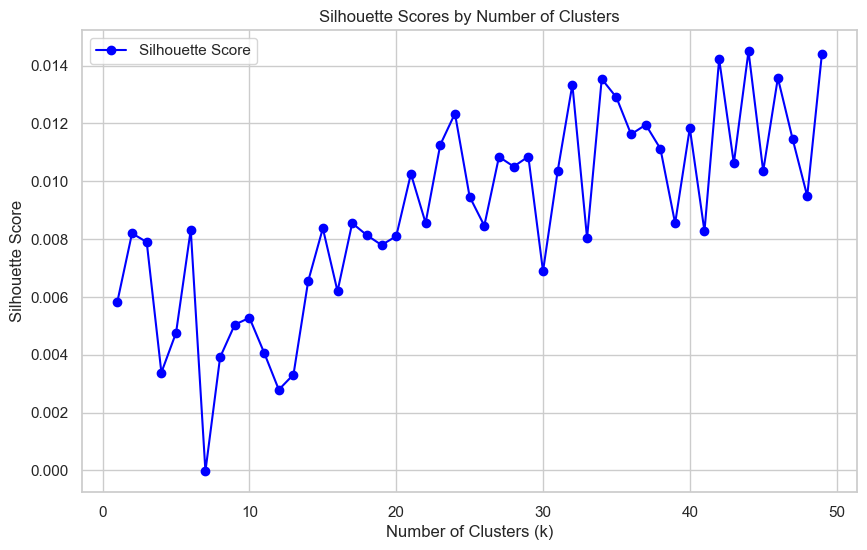

The best NMI score is: 0.1783068055336452 and the best Kappa: 47
The best AMI score is: 0.08668149644261673 and the best Kappa: 21
The best ARI score is: 0.0448315649547066 and the best Kappa: 9


In [12]:
from clustering_algorithms.kmeans import calc_kmeans
from utils.calc_tf_idf_features import calc_tf_idf_vectors

# define the corpus
corpus = initial_df.loc[:1000, text_col].to_list()

# calc TF-IDF features
transformed_data_tfidf = calc_tf_idf_vectors(corpus, df[text_col], nlp)

max_num_of_clusters = 50

# calculate the optimun kappa with KMeans via Silhouette score and using TF-IDF
kappa_kmeans_ft, scores_kmeans_ft, statistic_values_nmi, statistic_values_ari, statistic_values_ami = calc_kmeans(
    transformed_data_tfidf, max_num_of_clusters, true_labels=labels)

# print the scores NMI, AMI, ARI
print(f'The best NMI score is: {np.max(statistic_values_nmi)} and the best Kappa: {np.argmax(statistic_values_nmi) }')
print(f'The best AMI score is: {np.max(statistic_values_ami)} and the best Kappa: {np.argmax(statistic_values_ami) }')
print(f'The best ARI score is: {np.max(statistic_values_ari)} and the best Kappa: {np.argmax(statistic_values_ari) }')

#### USING FASTTEXT VECTORIZATION

Sentences transformed successfully via pretrained FastText language model


  8%|███████████▍                                                                                                                                   | 4/50 [00:00<00:04, 10.60it/s]

[2 2 2 2 1 0 1 2 1 0 0 2 2 0 2 2 0 1 0 1 2 0 2 1 1 0 1 2 0 2 2 1 2 0 0 2 2
 2 2 1 2 2 2 1 0 0 2 2 2 2 2 1 0 1 2 2 0 2 1 2 0 0 0 2 2 2 1 2 1 2 0 2 0 2
 1 0 0 2 2 2 0 0 0 2 0 2 2 2 1 1 2 0 2 0 2 0 2 2 1 0]


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:05<00:00,  8.70it/s]


The optimum kappa based on Silhouette score is: 2


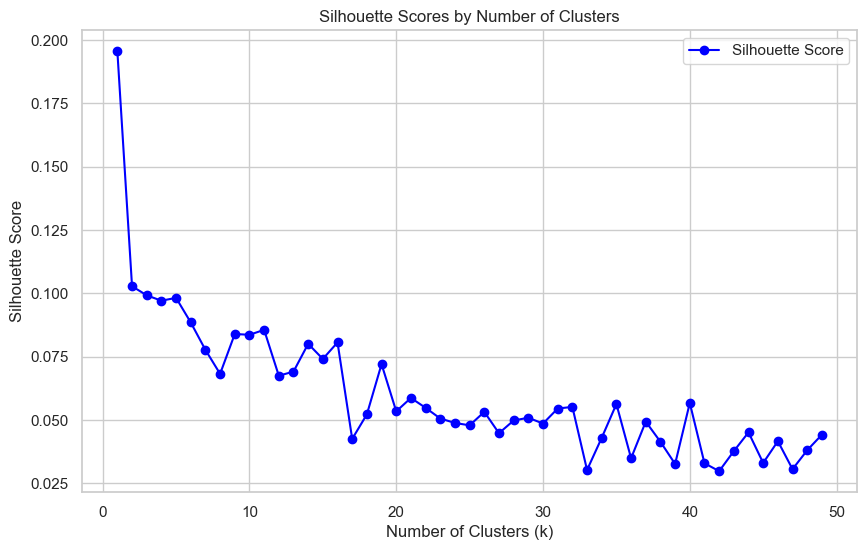

The best NMI score is: 0.18135315714667294 and the best Kappa: 45
The best AMI score is: 0.061376886160763096 and the best Kappa: 11
The best ARI score is: 0.038233269088872056 and the best Kappa: 11


In [4]:
from clustering_algorithms.kmeans import calc_kmeans
from utils.calc_embeddings_via_fasttext import train_fasttext_and_transform

# define the corpus
corpus = initial_df[text_col].to_list()

transformed_data_fasttext = train_fasttext_and_transform(corpus, df[text_col].to_list(), text_col)

max_num_of_clusters = 50
# calculate the optimun kappa with KMeans via Silhouette score and using FastText
kappa_kmeans_ft, scores_kmeans_ft, statistic_values_nmi, statistic_values_ari, statistic_values_ami = calc_kmeans(
    transformed_data_fasttext, max_num_of_clusters, true_labels=labels)

# print the scores NMI, AMI, ARI
print(f'The best NMI score is: {np.max(statistic_values_nmi)} and the best Kappa: {np.argmax(statistic_values_nmi) }')
print(f'The best AMI score is: {np.max(statistic_values_ami)} and the best Kappa: {np.argmax(statistic_values_ami) }')
print(f'The best ARI score is: {np.max(statistic_values_ari)} and the best Kappa: {np.argmax(statistic_values_ari) }')

#### USING SENTENCE TRANSFORMER EMBEDDINGS

C:\1. Python\LLM_mods_Topic_Modelling\venv\Lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Available device for the model is: 'cuda'
Calculation of embeddings completed succesfully


  8%|███████████▍                                                                                                                                   | 4/50 [00:00<00:03, 13.24it/s]

[1 1 2 1 1 2 2 1 1 1 2 1 1 0 1 2 2 1 0 2 2 1 2 1 1 2 1 1 0 2 1 1 1 2 2 1 1
 1 1 1 1 1 1 1 1 1 2 2 1 2 1 0 2 0 2 0 2 2 1 2 2 1 2 2 2 2 1 1 1 0 1 1 1 2
 1 2 2 2 2 1 2 1 2 2 0 1 2 2 0 1 1 1 1 1 1 0 2 2 2 1]


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:04<00:00, 11.11it/s]


The optimum kappa based on Silhouette score is: 3


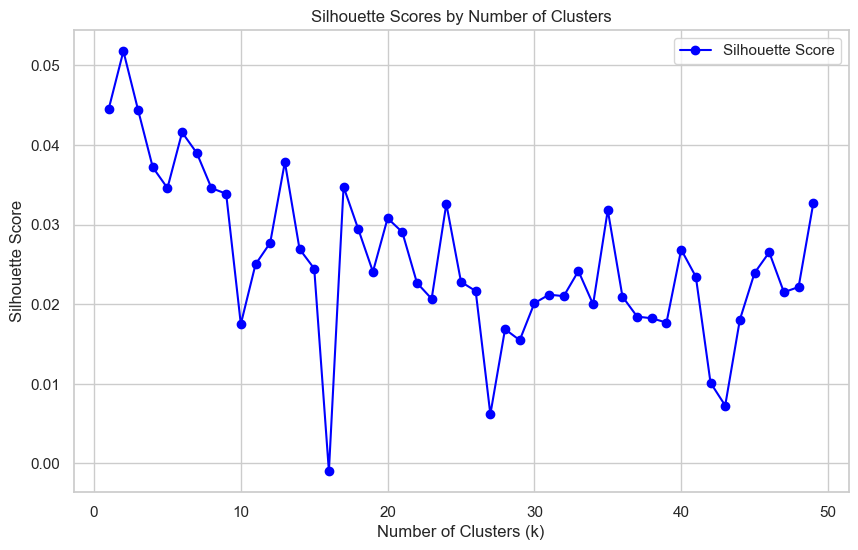

The best NMI score is: 0.1906563576775293 and the best Kappa: 48
The best AMI score is: 0.08402360666762683 and the best Kappa: 18
The best ARI score is: 0.04217651614661156 and the best Kappa: 18


In [8]:
from clustering_algorithms.kmeans import calc_kmeans
from utils.calc_embeddings_via_transformer import calc_embeddings
from sklearn.decomposition import PCA

transformed_data_embeddings = calc_embeddings(df[text_col].to_list())

# Reduce the dimensionality of embeddings
pca = PCA(n_components=50)  # Reduce to 50 dimensions or lower
reduced_data = pca.fit_transform(transformed_data_embeddings)

max_num_of_clusters = 50
# calculate the optimun kappa with KMeans via Silhouette score and using Embeddings from Transformer model
kappa_kmeans_ft, scores_kmeans_ft, statistic_values_nmi, statistic_values_ari, statistic_values_ami = calc_kmeans(
   reduced_data, max_num_of_clusters, true_labels=labels)

# print the scores NMI, AMI, ARI
print(f'The best NMI score is: {np.max(statistic_values_nmi)} and the best Kappa: {np.argmax(statistic_values_nmi) }')
print(f'The best AMI score is: {np.max(statistic_values_ami)} and the best Kappa: {np.argmax(statistic_values_ami) }')
print(f'The best ARI score is: {np.max(statistic_values_ari)} and the best Kappa: {np.argmax(statistic_values_ari) }')

### 2ND CLUSTERING TECHNIQUE: KMEANS CONSTRAINED (DEFINE MIN SIZE OF CLUSTERS)

#### USE SILHOUETTE SCORE AS STATISTICS VALUE AND TF-IDF VECTORIZATION

In [5]:
from clustering_algorithms.kmeans_constrained import get_number_of_clusters_with_statistic_constrained
max_num_of_clusters = 100

# calculate the optimun kappa with KMeans Constrained via Silhouette score and using TF-IDF
kappa_kmeans_cv_silhouette_tfidf, scores_kmeans_cv_silhouette_tfidf = get_number_of_clusters_with_statistic_constrained(
    transformed_data_tfidf, max_num_of_clusters, statistic_metric='silhouette'
)

 10%|██████████████                                                                                                                               | 10/100 [00:01<00:11,  8.15it/s]


ValueError: The product of size_min and n_clusters cannot exceed the number of samples (X)

#### USE SILHOUETTE SCORE AS STATISTICS VALUE AND FASTTEXT VECTORIZATION

In [60]:
# calculate the optimun kappa with KMeans Constrained via Silhouette score and using FastText
kappa_kmeans_cv_silhouette_ft, scores_kmeans_cv_silhouette_ft = get_number_of_clusters_with_statistic_constrained(
    transformed_data_fasttext, max_num_of_clusters, statistic_metric='silhouette'
)

NameError: name 'get_number_of_clusters_with_statistic_constrained' is not defined

### 3RD CLUSTERING TECHNIQUE: AGGLOMERATIVE

#### USING TF-IDF VECTORIZATION

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [02:34<00:00,  3.15s/it]

The optimal number of clusters based on Silhouette score is: 1


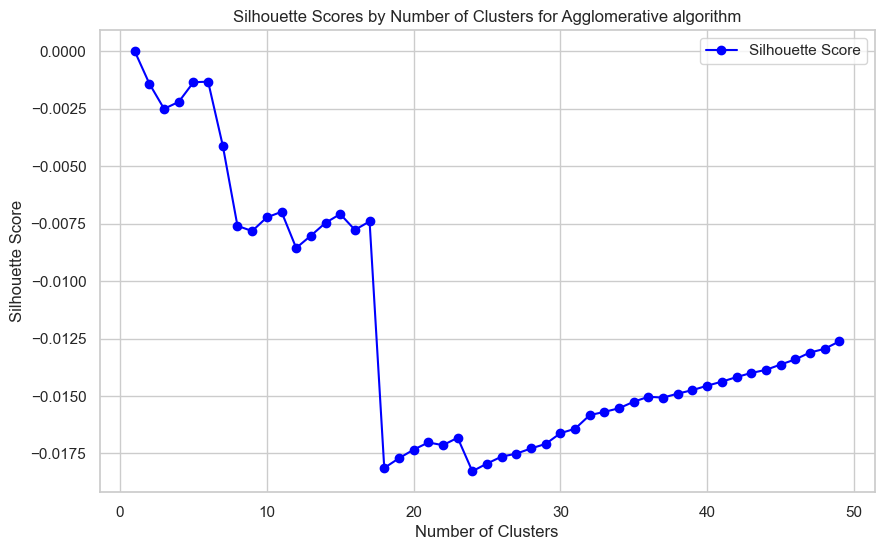

In [63]:
from clustering_algorithms.agglomerative import calc_agglomerative

cluster_values = range(1,50)

# calculate the optimun kappa with Agglomerative clustering algorithm via Silhouette score and using TF-IDF
kappa_agglomerative_tfidf, scores_agglomerative_tfidf = calc_agglomerative(transformed_data_tfidf, cluster_values)

#### USING FASTTEXT VECTORIZATION

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 99/99 [00:07<00:00, 14.12it/s]


The optimal number of clusters based on Silhouette score is: 2


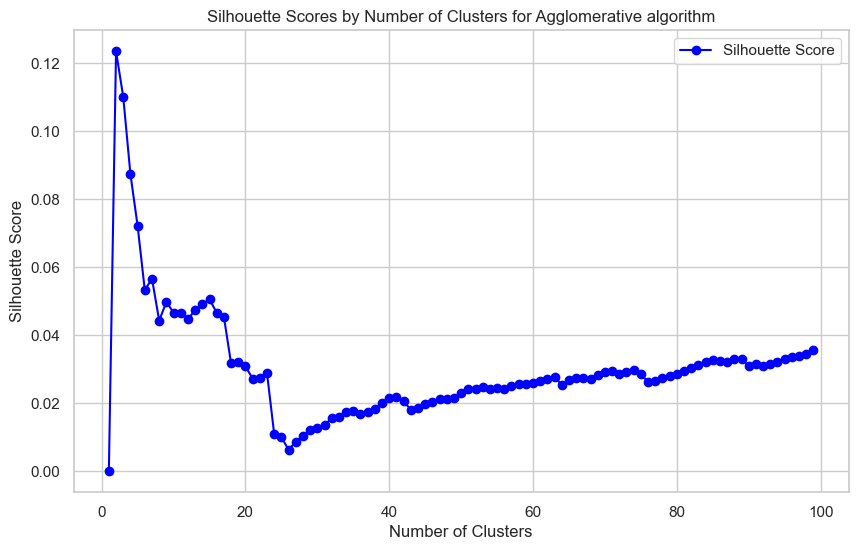

In [62]:
from clustering_algorithms.agglomerative import calc_agglomerative

cluster_values = range(1,100)

# calculate the optimun kappa with Agglomerative clustering algorithm via Silhouette score and using TF-IDF
kappa_agglomerative_ft, scores_agglomerative_ft = calc_agglomerative(transformed_data_fasttext, cluster_values)

### 4TH CLUSTERING TECHNIQUE: DBSCAN (DENSITY-BASED CLUSTERING NON-PARAMETRIC ALGORITHM)

#### USING TF-IDF VECTORIZATION

Suggested eps values:[1.08373218 1.08694555 1.09013128 1.09320133 1.09597954 1.09798219
 1.09988077 1.10251005 1.10374104 1.10696425 1.10890137 1.11110556
 1.1120914  1.11541039 1.11843946 1.12022754 1.1216928  1.12499048
 1.1261166  1.12747263 1.12897392 1.13115295 1.13284597 1.13431365
 1.13520177 1.13664201 1.13847858 1.14067411 1.14155211 1.14272161
 1.14488541 1.14593345 1.14753529 1.14858842 1.15061696 1.15203911
 1.15316719 1.1550506  1.15603603 1.15763365 1.15861427 1.15973323
 1.16077028 1.16149071 1.16212524 1.1630547  1.16384633 1.16511952
 1.16666447 1.16774075 1.16937763 1.17061241 1.17285566 1.17409188
 1.17499315 1.17555046 1.17649574 1.17771143 1.17943737 1.18129243
 1.18370825 1.18510797 1.18622311 1.18702908 1.18818643 1.18951829
 1.19116572 1.19203577 1.19265891 1.19372167 1.19559561 1.19641413
 1.19796246 1.19898807 1.20126307 1.20234631 1.20352532 1.20450335
 1.20578446 1.2075064  1.20930749 1.21008296 1.21130585 1.21237644
 1.21362685 1.21476246 1.21600752 1.21668

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:01<00:00, 10.67it/s]

The optimal eps based on Silhouette score is: 1e-05
The number of clusters for optimal eps is: 1


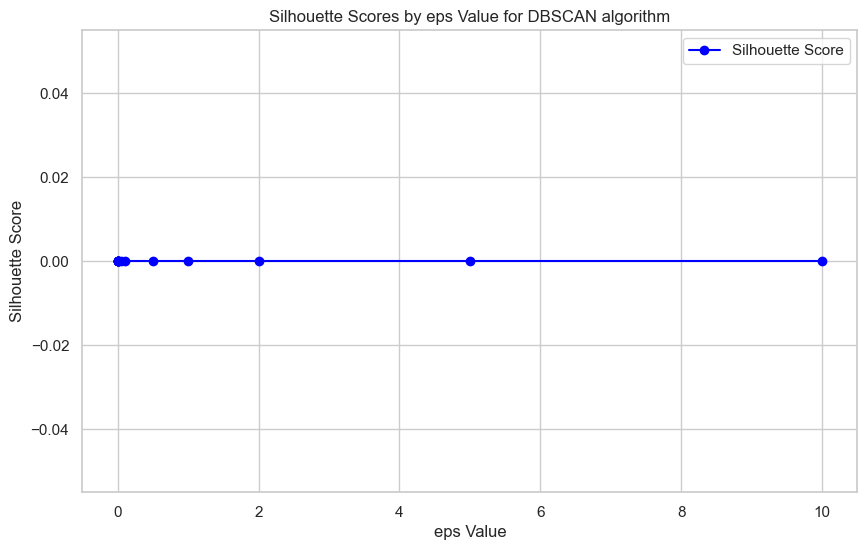

In [22]:
from clustering_algorithms.dbscan import generate_eps_values_via_nearest_neighbors, calc_dbscan

# Generate the best eps values based on the distance of the dataset
eps_values = generate_eps_values_via_nearest_neighbors(transformed_data_tfidf, num_values=100)
eps_values = [0.00001, 0.00005, 0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 2, 5, 10]
# calculate the optimun kappa with DBSCAN clustering algorithm via Silhouette score and using TF-IDF
optimal_eps_tfidf, kappa_dbscan_tfidf, scores_dbscan_tfidf = calc_dbscan(transformed_data_tfidf, eps_values)

#### USING FASTTEXT VECTORIZATION

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 72.46it/s]


The optimal eps based on Silhouette score is: 0.025
The number of clusters for optimal eps is: 2


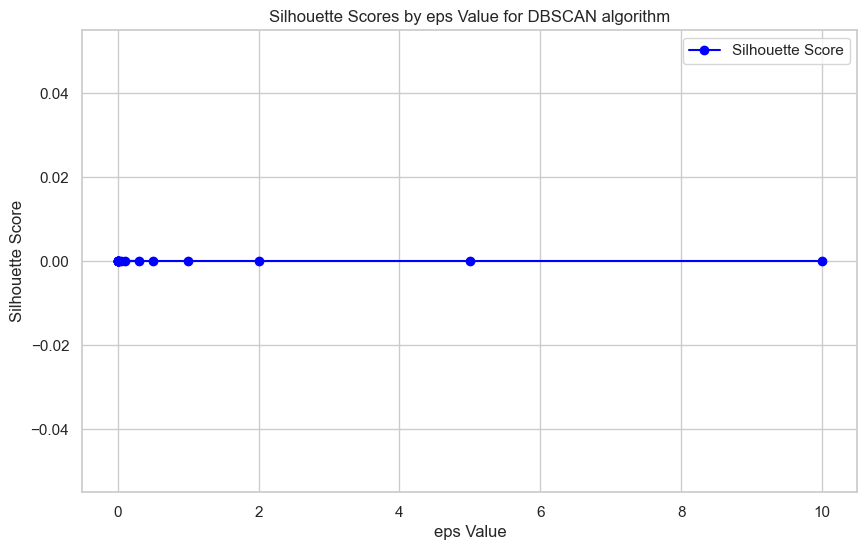

In [28]:
# Generate the best eps values based on the distance of the dataset
# eps_values = generate_eps_values_via_nearest_neighbors(transformed_data_fasttext, num_values=100)
eps_values = [0.025, 0.3, 0.00001, 0.00005, 0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 2, 5, 10]
# calculate the optimun kappa with DBSCAN clustering algorithm via Silhouette score and using FastText
optimal_eps_ft, kappa_dbscan_ft, scores_dbscan_ft = calc_dbscan(transformed_data_fasttext, eps_values)

### LOAD SECOND DATASET - 20NEWSGROUPS - A MORE DIFFICULT DATASET WITH MORE LABELS (GROUND TRUTH K=20)

In [1]:
from sklearn.datasets import fetch_20newsgroups
import pandas as pd
import numpy as np

data_20newsgroups = fetch_20newsgroups(subset='all', remove=('headers', 'footers', 'quotes'))
documents_20newsgroups = data_20newsgroups.data
labels_20newsgroups = data_20newsgroups.target
labels_names_20newsgroups = data_20newsgroups.target_names
df2_dict = {
    'label': labels_20newsgroups,
    'comment': documents_20newsgroups,
}
initial_df2 = pd.DataFrame(df2_dict)
initial_df2['label_name'] = initial_df2['label'].apply(lambda x: labels_names_20newsgroups[x])
initial_df2_cols = initial_df2.columns.to_list()
print(f'The length of the dataset 20newsgroups is: {len(initial_df2)}')
print(initial_df2_cols)
print(f'The unique labels of the dataset are:\n{initial_df2.label.unique()}\nThe labels names are:\n{initial_df2.label_name.unique()}')

The length of the dataset 20newsgroups is: 18846
['label', 'comment', 'label_name']
The unique labels of the dataset are:
[10  3 17  4 12 19 11 13  0  8  7  5  1 14 16  6  9 18  2 15]
The labels names are:
['rec.sport.hockey' 'comp.sys.ibm.pc.hardware' 'talk.politics.mideast'
 'comp.sys.mac.hardware' 'sci.electronics' 'talk.religion.misc'
 'sci.crypt' 'sci.med' 'alt.atheism' 'rec.motorcycles' 'rec.autos'
 'comp.windows.x' 'comp.graphics' 'sci.space' 'talk.politics.guns'
 'misc.forsale' 'rec.sport.baseball' 'talk.politics.misc'
 'comp.os.ms-windows.misc' 'soc.religion.christian']


#### KEEP A SAMPLE OF THE DATASET AND LOAD THE PRETRAINED SPACY MODEL

In [2]:
from sklearn.model_selection import train_test_split
from langdetect import detect, DetectorFactory
from utils.load_pretrained_spacy_model import load_pretrained_model

# define the column with the comments
text_col='comment'

x_train_news, x_test_news, y_train_news, y_test_news = train_test_split(
    initial_df2,
    initial_df2['label'],
    test_size=0.1,
    random_state=42,
    stratify=initial_df2['label']
)

nlp_pretrained_model = load_pretrained_model(df=x_test_news, text_col=text_col)

The language of the dataset is: en


### 1ST CLUSTERING TECHNIQUE: KMEANS

We are going to implement the original KMeans without using any constraints. For transforming the data we are going to use TF-IDF and FastText embeddings.

#### USING TF-IDF VECTORIZATION

C:\1. Python\LLM_mods_Topic_Modelling\venv\Lib\site-packages\sklearn\feature_extraction\text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
C:\1. Python\LLM_mods_Topic_Modelling\venv\Lib\site-packages\sklearn\feature_extraction\text.py:406: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ca', 'nt'] not in stop_words.
  warnings.warn(


Sentences transformed successfully via TF-IDF vectorizer


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:42<00:00,  1.17it/s]

The optimum kappa based on Silhouette score is: 23


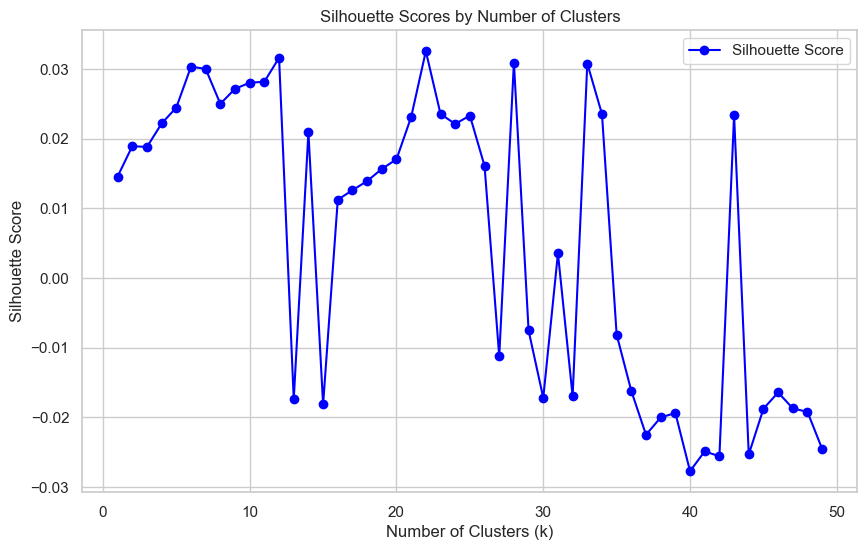

The best NMI score is: 0.0799861410376287 and the best Kappa: 42
The best AMI score is: 0.004824848740848193 and the best Kappa: 22
The best ARI score is: 0.0016182908321264804 and the best Kappa: 20


In [25]:
import spacy
from clustering_algorithms.kmeans import calc_kmeans
from utils.calc_tf_idf_features import calc_tf_idf_vectors

# define the spacy model
nlp = spacy.load(nlp_pretrained_model)

# define the corpus
corpus = initial_df2.loc[:1000, text_col].to_list()

# calc TF-IDF features
transformed_data_tfidf = calc_tf_idf_vectors(corpus, df2[text_col], nlp)

max_num_of_clusters = 50

# calculate the optimun kappa with KMeans via Silhouette score and using TF-IDF
kappa_kmeans_ft, scores_kmeans_ft, statistic_values_nmi, statistic_values_ari, statistic_values_ami = calc_kmeans(
    transformed_data_tfidf, max_num_of_clusters, true_labels=y_test_news)

# print the scores NMI, AMI, ARI
print(f'The best NMI score is: {np.max(statistic_values_nmi)} and the best Kappa: {np.argmax(statistic_values_nmi) }')
print(f'The best AMI score is: {np.max(statistic_values_ami)} and the best Kappa: {np.argmax(statistic_values_ami) }')
print(f'The best ARI score is: {np.max(statistic_values_ari)} and the best Kappa: {np.argmax(statistic_values_ari) }')

#### USING FASTTEXT VECTORIZATION

Sentences transformed successfully via pretrained FastText language model


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:25<00:00,  1.92it/s]

The optimum kappa based on Silhouette score is: 2


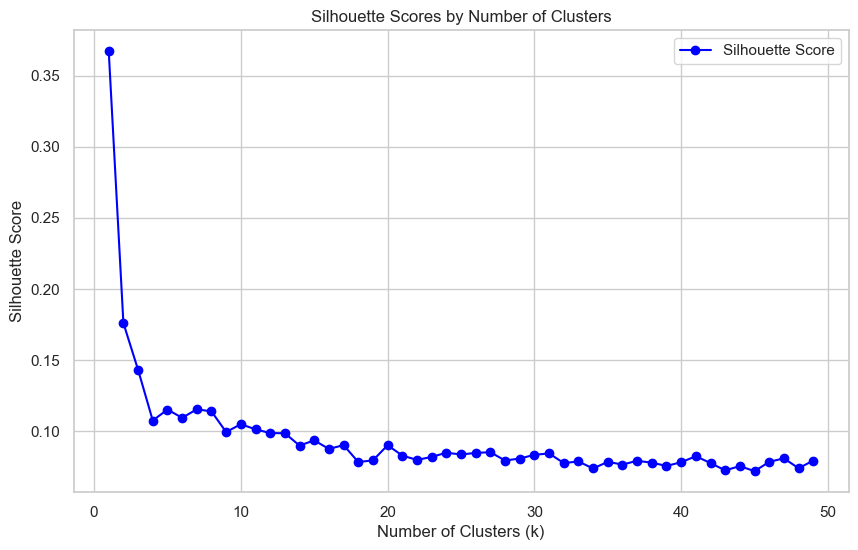

The best NMI score is: 0.07321268271557733 and the best Kappa: 48
The best AMI score is: 0.003128444399719062 and the best Kappa: 38
The best ARI score is: 0.00020971537185499915 and the best Kappa: 41


In [26]:
from clustering_algorithms.kmeans import calc_kmeans
from utils.calc_embeddings_via_fasttext import train_fasttext_and_transform

# define the corpus
corpus = initial_df2[text_col].to_list()

transformed_data_fasttext = train_fasttext_and_transform(corpus, df2[text_col].to_list(), text_col)

max_num_of_clusters = 50
# calculate the optimun kappa with KMeans via Silhouette score and using FastText
kappa_kmeans_ft, scores_kmeans_ft, statistic_values_nmi, statistic_values_ari, statistic_values_ami = calc_kmeans(
    transformed_data_fasttext, max_num_of_clusters, true_labels=y_test_news)

# print the scores NMI, AMI, ARI
print(f'The best NMI score is: {np.max(statistic_values_nmi)} and the best Kappa: {np.argmax(statistic_values_nmi) }')
print(f'The best AMI score is: {np.max(statistic_values_ami)} and the best Kappa: {np.argmax(statistic_values_ami) }')
print(f'The best ARI score is: {np.max(statistic_values_ari)} and the best Kappa: {np.argmax(statistic_values_ari) }')

#### USING SENTENCE TRANSFORMER EMBEDDINGS

In [3]:
x_test_news = x_test_news[:120]
y_test_news = y_test_news[:120]

In [4]:
import torch
import gc

# Collect garbage to free memory
gc.collect()
# Clear GPU memory cache
torch.cuda.empty_cache()

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:04<00:00, 10.68it/s]


The optimum kappa based on Silhouette score is: 29


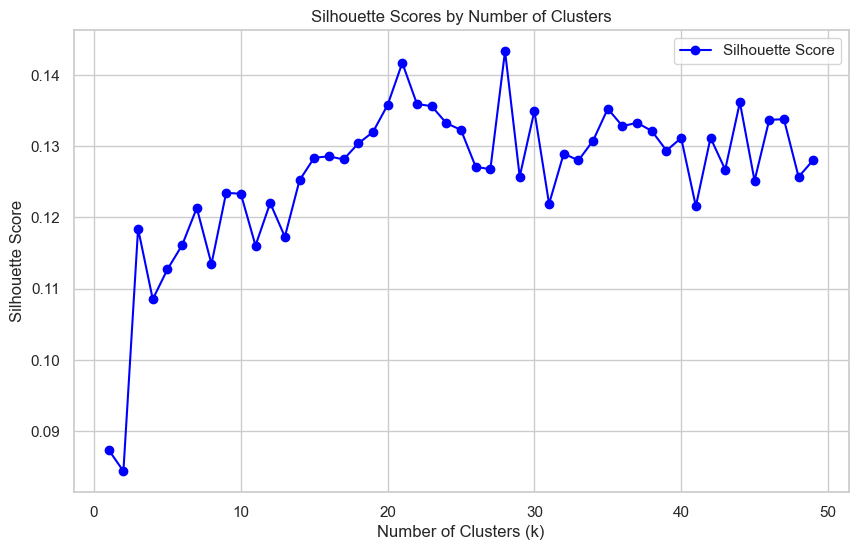

The best NMI score is: 0.7221184671509157 and the best Kappa: 46
The best AMI score is: 0.4463743828339952 and the best Kappa: 16
The best ARI score is: 0.32612550032600024 and the best Kappa: 20


In [17]:
from clustering_algorithms.kmeans import calc_kmeans
from utils.calc_embeddings_via_transformer import calc_embeddings
from sklearn.decomposition import PCA

# # transform the comments into embbeddings via sentence transformer
# transformed_data_embeddings = calc_embeddings(x_test_news[text_col].to_list())

# Reduce the dimensionality of embeddings
pca = PCA(n_components=32, svd_solver='auto')
reduced_data = pca.fit_transform(transformed_data_embeddings)

max_num_of_clusters = 50
# calculate the optimun kappa with KMeans via Silhouette score and using Embeddings from Transformer model
kappa_kmeans_ft, scores_kmeans_ft, statistic_values_nmi, statistic_values_ari, statistic_values_ami = calc_kmeans(
  reduced_data, max_num_of_clusters, true_labels=y_test_news)

# print the scores NMI, AMI, ARI
print(f'The best NMI score is: {np.max(statistic_values_nmi)} and the best Kappa: {np.argmax(statistic_values_nmi) }')
print(f'The best AMI score is: {np.max(statistic_values_ami)} and the best Kappa: {np.argmax(statistic_values_ami) }')
print(f'The best ARI score is: {np.max(statistic_values_ari)} and the best Kappa: {np.argmax(statistic_values_ari) }')

In [22]:
print(statistic_values_nmi[20])
print(len(statistic_values_ari))

0.685634881020119
49


### 2ND CLUSTERING TECHNIQUE: KMEANS CONSTRAINED (DEFINE MIN SIZE OF CLUSTERS)

#### USE SILHOUETTE SCORE AS STATISTICS VALUE AND TF-IDF VECTORIZATION

In [ ]:
from clustering_algorithms.kmeans_constrained import get_number_of_clusters_with_statistic_constrained
max_num_of_clusters = 20

# calculate the optimun kappa with KMeans Constrained via Silhouette score and using TF-IDF
kappa_kmeans_cv_silhouette_tfidf, scores_kmeans_cv_silhouette_tfidf = get_number_of_clusters_with_statistic_constrained(
   transformed_data_news_tfidf, max_num_of_clusters, statistic_metric='silhouette'
)

#### USE SILHOUETTE SCORE AS STATISTICS VALUE AND FASTTEXT VECTORIZATION

In [ ]:
# calculate the optimun kappa with KMeans Constrained via Silhouette score and using FastText
kappa_kmeans_cv_silhouette_ft, scores_kmeans_cv_silhouette_ft = get_number_of_clusters_with_statistic_constrained(
    transformed_data_news_fasttext, max_num_of_clusters, statistic_metric='silhouette'
)

### 3RD CLUSTERING TECHNIQUE: AGGLOMERATIVE

#### USING TF-IDF VECTORIZATION

In [ ]:
from clustering_algorithms.agglomerative import calc_agglomerative

cluster_values = range(1,100)

# calculate the optimun kappa with Agglomerative clustering algorithm via Silhouette score and using TF-IDF
kappa_agglomerative_tfidf, scores_agglomerative_tfidf = calc_agglomerative(transformed_data_news_tfidf, cluster_values)

#### USING FASTTEXT VECTORIZATION

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 99/99 [00:22<00:00,  4.37it/s]

The optimal number of clusters based on Silhouette score is: 2


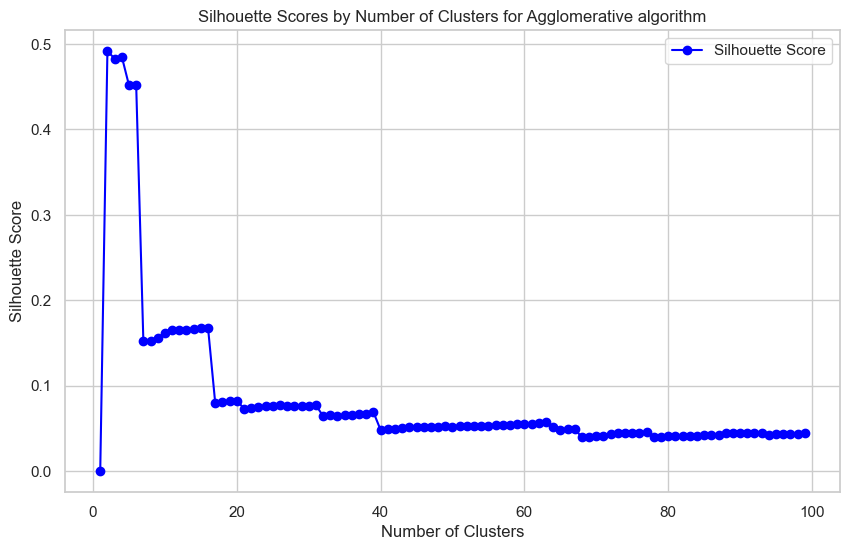

In [66]:
from clustering_algorithms.agglomerative import calc_agglomerative

cluster_values = range(1,100)

# calculate the optimun kappa with Agglomerative clustering algorithm via Silhouette score and using TF-IDF
kappa_agglomerative_ft, scores_agglomerative_ft = calc_agglomerative(transformed_data_news_fasttext, cluster_values)

### 4TH CLUSTERING TECHNIQUE: DBSCAN (DENSITY-BASED CLUSTERING NON-PARAMETRIC ALGORITHM)

#### USING TF-IDF VECTORIZATION

Suggested eps values:[1.08373218 1.08694555 1.09013128 1.09320133 1.09597954 1.09798219
 1.09988077 1.10251005 1.10374104 1.10696425 1.10890137 1.11110556
 1.1120914  1.11541039 1.11843946 1.12022754 1.1216928  1.12499048
 1.1261166  1.12747263 1.12897392 1.13115295 1.13284597 1.13431365
 1.13520177 1.13664201 1.13847858 1.14067411 1.14155211 1.14272161
 1.14488541 1.14593345 1.14753529 1.14858842 1.15061696 1.15203911
 1.15316719 1.1550506  1.15603603 1.15763365 1.15861427 1.15973323
 1.16077028 1.16149071 1.16212524 1.1630547  1.16384633 1.16511952
 1.16666447 1.16774075 1.16937763 1.17061241 1.17285566 1.17409188
 1.17499315 1.17555046 1.17649574 1.17771143 1.17943737 1.18129243
 1.18370825 1.18510797 1.18622311 1.18702908 1.18818643 1.18951829
 1.19116572 1.19203577 1.19265891 1.19372167 1.19559561 1.19641413
 1.19796246 1.19898807 1.20126307 1.20234631 1.20352532 1.20450335
 1.20578446 1.2075064  1.20930749 1.21008296 1.21130585 1.21237644
 1.21362685 1.21476246 1.21600752 1.21668

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:19<00:00,  5.01it/s]

The optimal eps based on Silhouette score is: 1.0837321846361068
The number of clusters for optimal eps is: 2


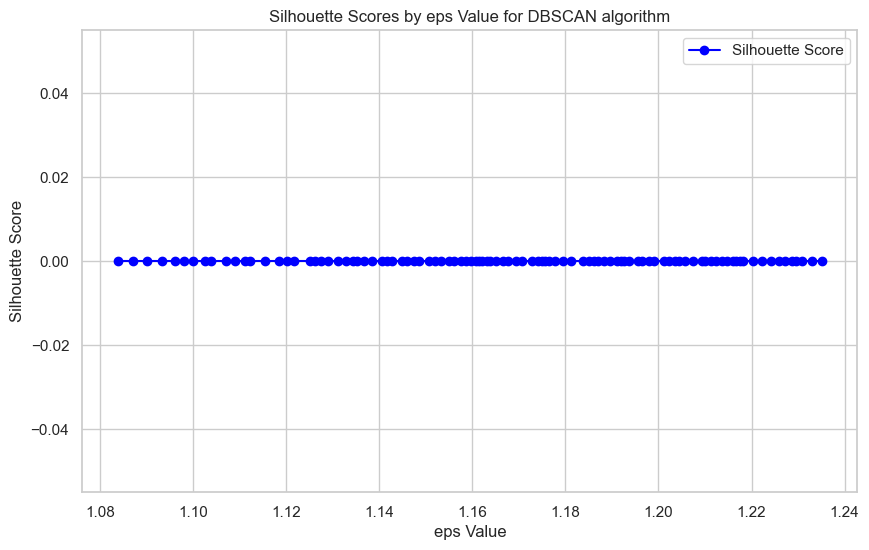

In [30]:
from clustering_algorithms.dbscan import generate_eps_values_via_nearest_neighbors, calc_dbscan

# Generate the best eps values based on the distance of the dataset
eps_values = generate_eps_values_via_nearest_neighbors(transformed_data_tfidf, num_values=100)

# calculate the optimun kappa with DBSCAN clustering algorithm via Silhouette score and using TF-IDF
optimal_eps_tfidf, kappa_dbscan_tfidf, scores_dbscan_tfidf = calc_dbscan(transformed_data_news_tfidf, eps_values)

#### USING FASTTEXT VECTORIZATION

Suggested eps values:[0.01674839 0.01685766 0.01709097 0.01715278 0.01736742 0.017478
 0.01760425 0.01766995 0.01776997 0.01789351 0.01799958 0.0181775
 0.01825249 0.01836836 0.01846593 0.01854909 0.01861766 0.0187883
 0.01884829 0.01901204 0.0191505  0.01926596 0.01938464 0.01944985
 0.01953625 0.01964393 0.0197191  0.01987686 0.01997298 0.02015237
 0.0202366  0.02037243 0.02044862 0.02056109 0.02067212 0.02082226
 0.02089162 0.02108775 0.0211949  0.0213111  0.0213928  0.02156386
 0.02167253 0.02177446 0.02189753 0.02207539 0.02226427 0.02238355
 0.02251322 0.02255815 0.02268564 0.02275752 0.02280506 0.02291024
 0.02300365 0.02307382 0.02320731 0.02327054 0.02343678 0.02352811
 0.02365736 0.02371284 0.02378293 0.02393082 0.02406294 0.02419991
 0.02433877 0.02438019 0.02455997 0.02472277 0.02483994 0.02491746
 0.02497936 0.025134   0.02526493 0.02539545 0.02550696 0.02558245
 0.02567343 0.02585809 0.02605435 0.02627814 0.02648001 0.02668546
 0.02686302 0.02706829 0.02733127 0.02740799 

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 56.52it/s]


The optimal eps based on Silhouette score is: 0.016748389415442943
The number of clusters for optimal eps is: 1


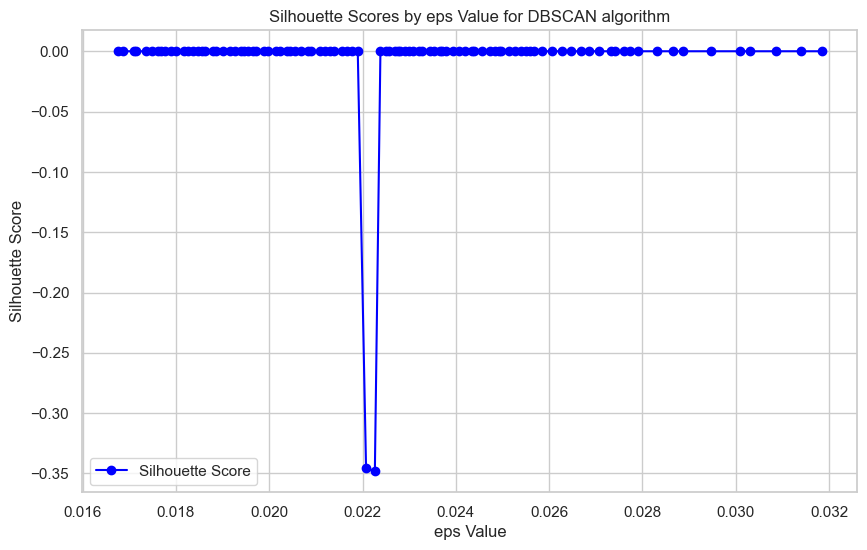

In [31]:
# Generate the best eps values based on the distance of the dataset
eps_values = generate_eps_values_via_nearest_neighbors(transformed_data_fasttext, num_values=100)

# calculate the optimun kappa with DBSCAN clustering algorithm via Silhouette score and using FastText
optimal_eps_ft, kappa_dbscan_ft, scores_dbscan_ft = calc_dbscan(transformed_data_news_fasttext, eps_values)

### 5TH CLUSTERING TECHNIQUE: hDBSCAN (HIERARCHICAL DENSITY-BASED CLUSTERING NON-PARAMETRIC ALGORITHM)

#### USING TF-IDF VECTORIZATION

In [9]:
from clustering_algorithms.hdbscan import calc_hdbscan

maximum_cluster_size_values = [i for i in range(5, 105, 5)]
# calculate the optimun kappa with DBSCAN clustering algorithm via Silhouette score and using TF-IDF
optimal_eps_hdbscan_tfidf, kappa_hdbscan_tfidf, scores_hdbscan_tfidf = calc_hdbscan(transformed_data_news_tfidf, maximum_cluster_size_values)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:09<00:00,  2.16it/s]


NameError: name 'min_cluster_size_values' is not defined

[0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95]
